Weight Uncertainty in Neural Networks, Blundell et. al.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import itertools
import importlib

import sys
sys.path.append("..")
from training.util import GaussianMixture
from training import bbb, util

In [19]:
importlib.reload(bbb)

<module 'training.bbb' from 'd:\\Uni\\Bachelorarbeit\\VariationalBayesianDL\\repro\\..\\training\\bbb.py'>

Epoch 0: loss 2.867413282394409
Epoch 10: loss 2.7959725856781006
Epoch 20: loss 2.7956392765045166
Epoch 30: loss 2.7958829402923584
Epoch 40: loss 2.7952895164489746
Epoch 50: loss 2.7941854000091553
Epoch 60: loss 2.794682025909424
Epoch 70: loss 2.794407844543457
Epoch 80: loss 2.7931859493255615
Epoch 90: loss 2.793890953063965
Epoch 100: loss 2.794369697570801
Epoch 110: loss 2.793063163757324
Epoch 120: loss 2.794504165649414
Epoch 130: loss 2.793743371963501
Epoch 140: loss 2.792853593826294
Epoch 150: loss 2.793654441833496
Epoch 160: loss 2.7933318614959717
Epoch 170: loss 2.7942864894866943
Epoch 180: loss 2.7932465076446533
Epoch 190: loss 2.7932589054107666
Epoch 200: loss 2.7928736209869385
Epoch 210: loss 2.793475866317749
Epoch 220: loss 2.793247938156128
Epoch 230: loss 2.7936575412750244
Epoch 240: loss 2.7937979698181152
Epoch 250: loss 2.7932851314544678
Epoch 260: loss 2.793111562728882
Epoch 270: loss 2.7940073013305664
Epoch 280: loss 2.7930562496185303
Epoch 290

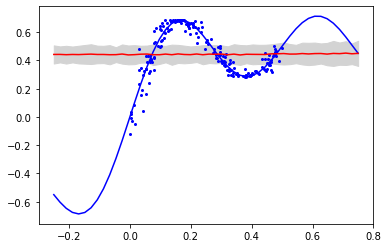

In [28]:
# 5.1: Regression curves (optimized using the Local Reparametrization Trick and a single normal distribution as the prior)

from training import toy
importlib.reload(toy)

torch.manual_seed(42)
device = torch.device("cpu")

batch_size = 5
trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

model = nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device, mc_sample=2, sampling="activations"),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device, mc_sample=2, sampling="activations")
)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(500):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")

def eval_bbb(input):
    samples = 100
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
trainset.plot(eval_bbb)